In [1]:
import pandas as pd
import plotnine as pn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Import data

In [2]:
#Import Pooja's data
dat = pd.read_table("data/endpoint_data.txt")

#Import data from my old experiments
files = !ls data/plate*
file_list = []
for file in files:
    file_list.append(pd.read_table(file))
dat2 = pd.concat(file_list)

# Format data

In [11]:
#Filter data
#Keep only wells that that started at 0.05 OD and used 20ul of phage
dat2 = dat2.query("bacteria==0.05 & volume==20")

#Rename host column
dat = dat.rename(columns={"Host":"Strain"})

dat2 = dat2.replace({"Host\r\nControl":"Host Control"})

###################################
#Format phage strings
phages=["bop","car","bob","ccs1","ccs2","ccs3","ump","carl","bill","ben","sds1","sds2","pg2","pg9","pg11","pg13","v12"]
phage_to_upper = {"bop":"Bop",
                 "car":"Car",
                  "bob":"Bob",
                 "ccs1":"CCS1",
                 "ccs2":"CCS2",
                 "ccs3":"CCS3",
                 "ump":"Ump",
                 "carl":"Carl",
                 "bill":"Bill",
                 "ben":"Ben",
                 "sds1":"SDS1",
                 "sds2":"SDS2",
                 "pg2":"PG2",
                 "pg9":"PG9",
                 "pg11":"PG11",
                 "pg13":"PG13",
                 "v12":"V12"}
phage_order = ["V12","Bop","Ben","Bob","Bill","Car","Carl","CCS1","SDS1","SDS2","CCS2","CCS3","PG2","PG9","PG11","PG13","Ump"]

def parse_phages(text):
    '''
    Takes in a text string with phages in it and returns a list of the phages
    '''
    text_lower = str.lower(text)
    phage_list = []
    #Deal with car and carl
    if "carl" in text_lower:
        phage_list.append("carl")
        text_lower = text_lower.replace("carl","")
    for phage in phages:
        if phage in text_lower:
            phage_list.append(phage)
    phage_list = [phage_to_upper[x] for x in phage_list]
    return(phage_list)
       

dat["phage_list"] = dat.Phage.apply(func=parse_phages) 
dat2["phage_list"] = dat2.Phages.apply(func=parse_phages)    

###################################

#Get MOI column names
highest_MOI_cols = ['MOI 0.1','MOI 0.1.1','MOI 0.1.2']
MOI_cols = ['MOI 0.1',
 'MOI 0.1.1',
 'MOI 0.1.2',
 'MOI 0.01',
 'MOI 0.01.1',
 'MOI 0.01.2',
 'MOI 0.001',
 'MOI 0.001.1',
 'MOI 0.001.2']
dat_format = dat.loc[:,["Strain","phage_list"] + MOI_cols]\
    .melt(id_vars=["Strain","phage_list"])
#Format MOI data from Pride lab
dat_format["MOI"] = pd.Categorical(['.'.join(x.replace("MOI ","").split('.')[:2]) for x in dat_format.variable], 
                                           ordered=True,
                                           categories=["0.001","0.01","0.1"])
dat_format.drop(columns="variable", inplace=True)

#Subset columns of Whiteson data
dat2_format = dat2.loc[:,["Strain","phage_list","value"]]
dat2_format["MOI"] = ''


#Add in lab that performed experiment
dat_format["experimenter"] = "Pride"
dat2_format["experimenter"] = "Whiteson"

#Get bacteria only Pride wells
pride_positives = dat.loc[:,["Strain","Positive control","Positive control.1","Positive control.2"]]\
                    .melt(id_vars="Strain")\
                    .drop(columns="variable")
pride_positives["experimenter"] = "Pride"
pride_positives["phage_list"] = [[] for x in range(pride_positives.shape[0])]
pride_positives["MOI"] = 0

#Merge data
dat_merged = pd.concat([dat_format, dat2_format,pride_positives])

#Add in phage count
dat_merged["phage_count"] = [len(x) for x in dat_merged.phage_list]

#Fromat phage string
dat_merged["phage_string"] = [','.join(x) for x in dat_merged.phage_list]

dat_merged = dat_merged.replace({"Yi6":"YI6"})

#Subtract media blank .107 taken from average of all negative wells
blank_val = .107
dat_merged["value"] = [x - blank_val for x in dat_merged["value"]]

#Split off data for MOI plots
dat_merged_moi = dat_merged.query('MOI != ""')

#Get data with just Pride highest MOI and all Whiteson (unknown MOI)
MOI_to_keep = [0,"0.1",""]
dat_merged = dat_merged.query('MOI in @MOI_to_keep')


dat_merged.head()

,Strain,phage_list,value,MOI,experimenter,phage_count,phage_string
0,YI6,[Bop],-0.0014,0.1,Pride,1,Bop
1,YI6,[Car],0.0674,0.1,Pride,1,Car
2,YI6,[CCS1],0.1690,0.1,Pride,1,CCS1
3,YI6,[CCS3],-0.0026,0.1,Pride,1,CCS3
4,YI6,[Ump],0.0150,0.1,Pride,1,Ump


_____

# Plot

Helper stuff

In [17]:
phage_type_dict = {"Bop":"M",
                   "Bob":"M",
                 "Car":"M",
                 "CCS1":"M",
                 "CCS2":"S",
                 "CCS3":"S",
                 "Ump":"P",
                 "Carl":"M",
                 "Bill":"M",
                 "Ben":"M",
                 "SDS1":"S",
                 "SDS2":"S",
                 "PG2":"S",
                 "PG9":"S",
                 "PG11":"S",
                 "PG13":"S",
                 "V12":"M"}
phage_order = ["V12","Bop","Ben","Bob","Bill","Car","Carl","CCS1","SDS1","SDS2","CCS2","CCS3","PG2","PG9","PG11","PG13","Ump"]
phage_subtype = {x:"{}({})".format(x,phage_type_dict[x]) for x in phage_order}

color_dict = {"M":"blue",
             "S":"red",
             "P":"green"}

def format_phage_colors(phage_string, color_dict = color_dict):
    out_string = ''
    if phage_string=='' or phage_string=="phage_string":
        return(out_string)
    phage_list = phage_string.split(',')
    ordered_list = pd.Categorical(phage_list, categories= phage_order, ordered=True).sort_values().to_list()
    for phage in ordered_list:
        out_string += r'\textcolor{%s}{%s} ' % (color_dict[phage_type_dict[phage]], phage)
    return(out_string)
def order_pahge_string(phage_string):
    if phage_string=='' or phage_string=="phage_string":
        return('')
    phage_list = phage_string.split(',')
    ordered_list = pd.Categorical(phage_list, categories= phage_order, ordered=True).sort_values().to_list()
    ordered_list_with_subtype = [phage_subtype[x] for x in ordered_list]
    return(' - '.join(ordered_list_with_subtype))

phage_types = {"Myoviridae":["V12","Bop","Ben","Bill","Car","Carl","CCS1"],
              "Siphoviridae":["CCS2","CCS3","SDS1","SDS2","PG2","PG9","PG11","PG13"],
              "Podoviridae":["Ump"]}

def make_boxplot(dat_merged,bac, number_titles=True, ymax=1):
    temp_dat=dat_merged.query('Strain==@bac')
    pcs=sorted(list(set(temp_dat.phage_count)))
    n_frames = len(pcs)
    width_ratios = [len(set(temp_dat.query('phage_count==@pc').phage_string)) for pc in pcs]
    total_width = len(set(temp_dat.phage_string)) *.4
    colors=["white",'#a6cee3','#b2df8a','#fb9a99']
    fig,axs =  plt.subplots(1,n_frames, figsize=(total_width,4), 
                            gridspec_kw={'width_ratios': width_ratios} )

    fig.subplots_adjust(wspace=.1)
    
    
    
    for n in range(n_frames):
        pc=pcs[n]
        axs[n].margins(x=2)
        data_subset= dat_merged.query('phage_count == @pc & Strain == @bac')
        #Get phage order
        phage_order = data_subset.groupby("phage_string").agg({"value":"mean"}).sort_values("value").index
        
        #Grid
        axs[n].yaxis.grid(color='gray', linestyle='dashed')
        axs[n].set_axisbelow(True)
        
        sns.boxplot(data=data_subset,
                x= "phage_string",
                y="value",
                ax=axs[n],
                    width=.7,
                    fliersize=0,
                    order = phage_order,
                    hue="phage_count",
                    palette={x:c for x,c in zip([0,1,2,3],colors)})
              #  palette=["red","green","orange","blue"])

        sns.swarmplot(data=data_subset, 
                    x="phage_string", 
                    y="value", 
                    color="black",
                      order=phage_order,
                      size=3,
                      alpha=.6,
                    ax=axs[n])

        #Set y-limits
        axs[n].set_ylim(-.05,ymax)
        
        
        
        #Alter x labels
        labels = [order_pahge_string(item.get_text()) for item in axs[n].get_xticklabels()]
        axs[n].set_xticklabels(labels, size=14)
        for label in axs[n].get_xticklabels():
            label.set_ha("center")
            label.set_rotation(90)
        if n==0  and pc==0:
            axs[n].set_xticklabels(["No Phage"])
        #Axis y labels
        if n == 0 :
            axs[n].tick_params(axis = 'y', which = 'major', labelsize = 14)
        else:
            axs[n].set_yticklabels([])
            
        #Axis titles
        axs[n].set_xlabel('')
        if n==0:
            axs[n].set_ylabel('OD600 After 72 Hours', size=18)
        else:
            axs[n].set_ylabel('')
        #Plot titles
        if n==0 and pc==0:
            axs[n].set_title('')
        else:
            if number_titles:
                title_d = {0:'',1:"1 Phage",2:"2 Phages",3:"3 Phages"}
                axs[n].set_title(title_d[pc], size=18)
        #Legend
        axs[n].get_legend().remove()

        for i,box in enumerate(axs[n].artists):
            box.set_edgecolor('black')
            #box.set_facecolor('white')

            for j in range(6*i,6*(i+1)):
                 axs[n].lines[j].set_color('black')
        

## Plot data with only highest MOI
Merge Pride and Whiteson data. Pride data at 0.1 MOI (Highest)

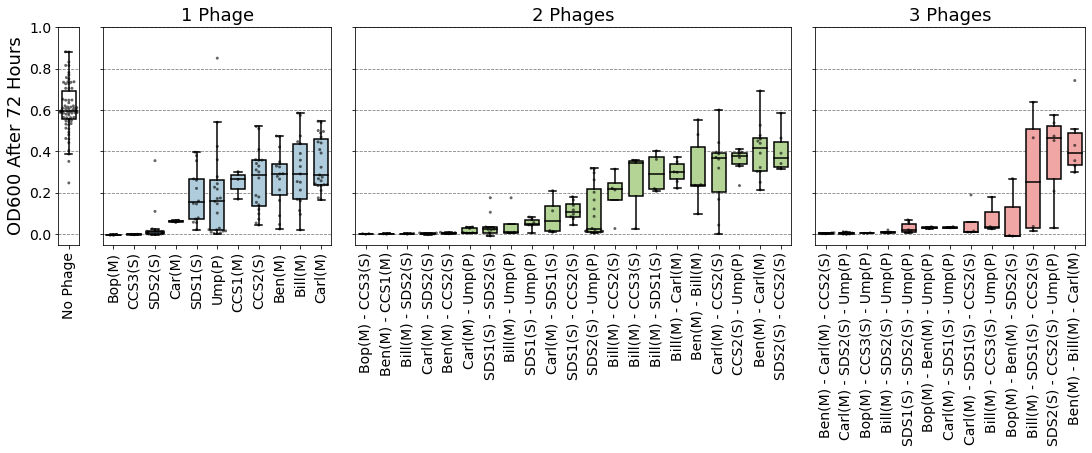

In [16]:
#NEW
make_boxplot(dat_merged,"YI6")


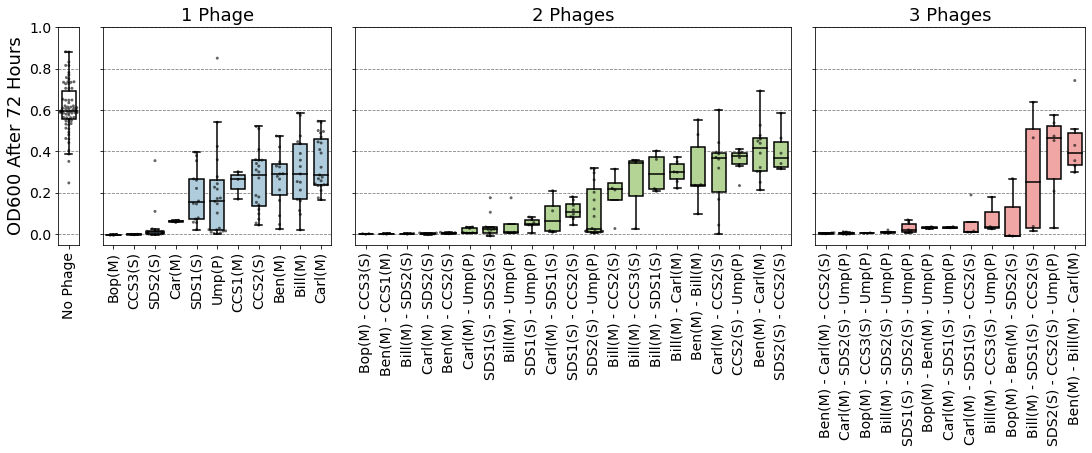

In [22]:
#NEW
make_boxplot(dat_merged,"YI6")


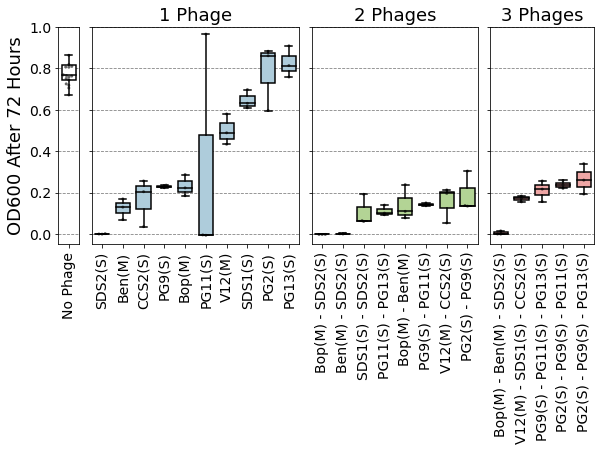

In [17]:
#NEW
make_boxplot(dat_merged,"EF06")

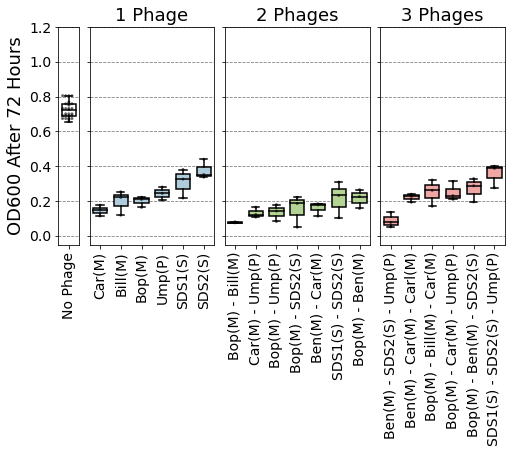

In [18]:
make_boxplot(dat_merged,"EF11", ymax=1.2)

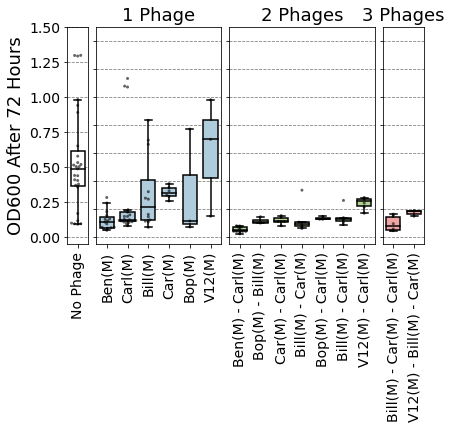

In [28]:
make_boxplot(dat_merged,"V587", ymax=1.5)

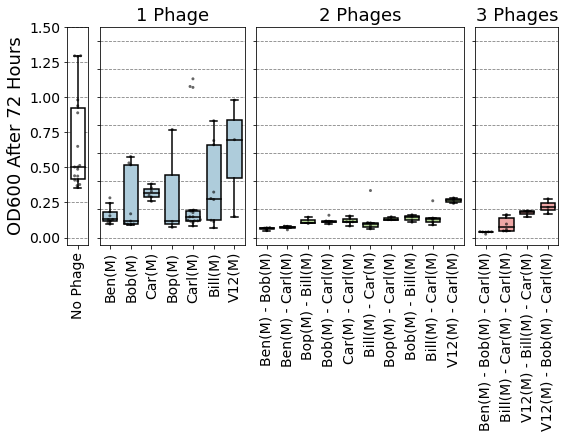

In [18]:
make_boxplot(dat_merged,"V587", ymax=1.5)

___

## Plot working cocktails separately

In [20]:
def filter_df(df, num_phages, phages_to_exclude):
    if type(num_phages) == int:
        num_phages = [num_phages]
    df = df.query('phage_count in @num_phages')
    df = df.loc[[all([phage not in phages_to_exclude for phage in x.split(',')]) for x in df.phage_string]]
    return(df)

def inverse_filter_df(df, num_phages, phages_to_exclude):
    if type(num_phages) == int:
        num_phages = [num_phages]
    df = df.query('phage_count in @num_phages')
    df = df.loc[[any([phage in phages_to_exclude for phage in x.split(',')]) or x=='' for x in df.phage_string]]
    return(df)


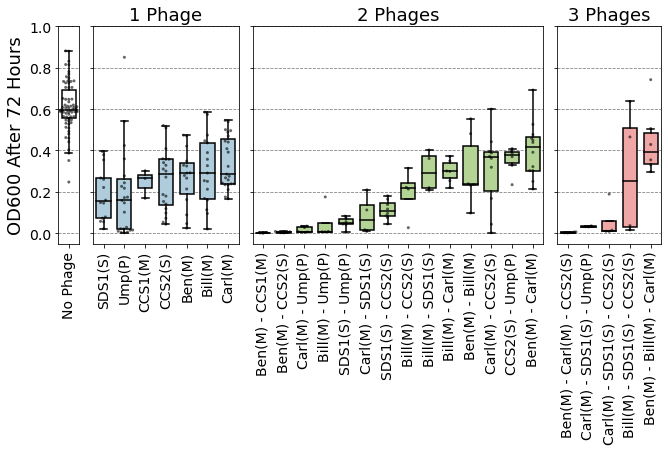

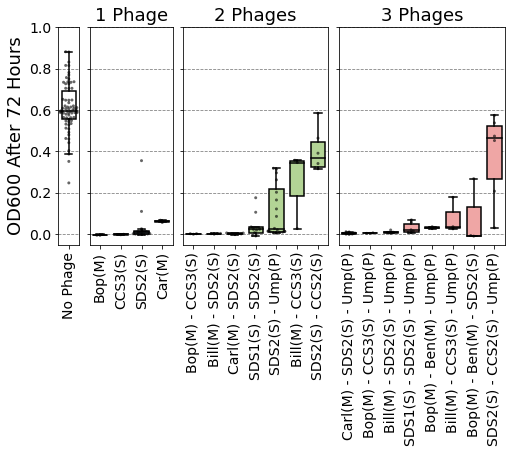

In [23]:
plot_dat = filter_df(dat_merged, [0,1,2,3], ["Bop","CCS3","SDS2","Car"])
plot_dat_i = inverse_filter_df(dat_merged, [0,1,2,3], ["Bop","CCS3","SDS2","Car"])
make_boxplot(plot_dat,"YI6")
make_boxplot(plot_dat_i,"YI6")


___

## Plot different MOIs of Pride data

Function to plot MOI curves

In [29]:
def make_moi_boxplot(dat_merged,bac, number_titles=True):
    temp_dat=dat_merged.query('Strain==@bac')
    width_ratios = [len(set(temp_dat.query('phage_count==@pc').phage_string)) for pc in [0,1,2,3]]
    total_width = len(set(dat_merged.query('Strain==@bac').phage_string)) *.8
    colors=["white",'#a6cee3','#b2df8a','#fb9a99']
    fig,axs =  plt.subplots(1,4, figsize=(total_width,4), 
                            gridspec_kw={'width_ratios': width_ratios} )

    fig.subplots_adjust(wspace=.1)
    
    for n in [0,1,2,3]:
        axs[n].margins(x=2)
        data_subset= dat_merged.query('phage_count == @n & Strain == @bac')
        #Get phage order
        phage_order = data_subset.groupby("phage_string").agg({"value":"mean"}).sort_values("value").index
        
        #Grid
        axs[n].yaxis.grid(color='gray', linestyle='dashed')
        axs[n].set_axisbelow(True)
        
        sns.boxplot(data=data_subset,
                x= "phage_string",
                y="value",
                ax=axs[n],
                    width=.7,
                    fliersize=0,
                    order = phage_order,
                    hue="MOI",
                    palette={x:c for x,c in zip([0,"0.1","0.01","0.001"],colors)})
              #  palette=["red","green","orange","blue"])

        sns.swarmplot(data=data_subset, 
                    x="phage_string", 
                    y="value", 
                    color="black",
                      order=phage_order,
                      size=3,
                      alpha=.6,
                    ax=axs[n])

        #Set y-limits
        axs[n].set_ylim(-.05,1)
        
        
        
        #Alter x labels
        labels = [order_pahge_string(item.get_text()) for item in axs[n].get_xticklabels()]
        axs[n].set_xticklabels(labels, size=14)
        for label in axs[n].get_xticklabels():
            label.set_ha("center")
            label.set_rotation(90)
        if n==0:
            axs[n].set_xticklabels(["No Phage"])
            
        #Axis y labels
        if n == 0 :
            axs[n].tick_params(axis = 'y', which = 'major', labelsize = 14)
        else:
            axs[n].set_yticklabels([])

        #Axis titles
        axs[n].set_xlabel('')
        if n==0:
            axs[n].set_ylabel('OD600 After 72 Hours', size=18)
        else:
            axs[n].set_ylabel('')
        #Plot titles
        if n==0:
            axs[n].set_title('')
        else:
            if number_titles:
                title_d = {1:"1 Phage",2:"2 Phages",3:"3 Phages"}
                axs[n].set_title(title_d[n], size=18)
        #Legend
        if n!=3:
            axs[n].get_legend().remove()
        else:
            lgd = axs[n].legend(bbox_to_anchor=(1.01, 1), loc='upper left', prop={'size': 15})
            lgd.set_title('MOI',prop={'size':20})
            
        for i,box in enumerate(axs[n].artists):
            box.set_edgecolor('black')
            #box.set_facecolor('white')

            for j in range(6*i,6*(i+1)):
                 axs[n].lines[j].set_color('black')

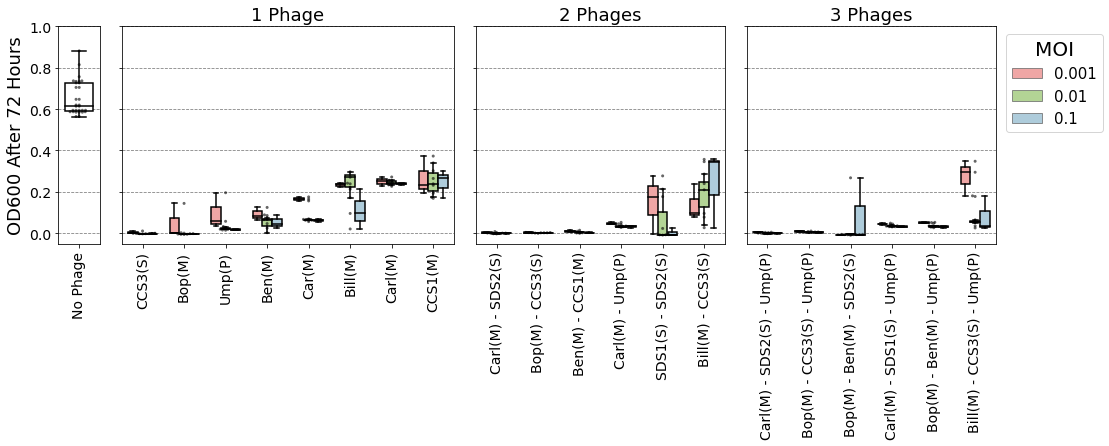

In [30]:
bac="YI6"
make_moi_boxplot(dat_merged_moi,bac, number_titles=True)

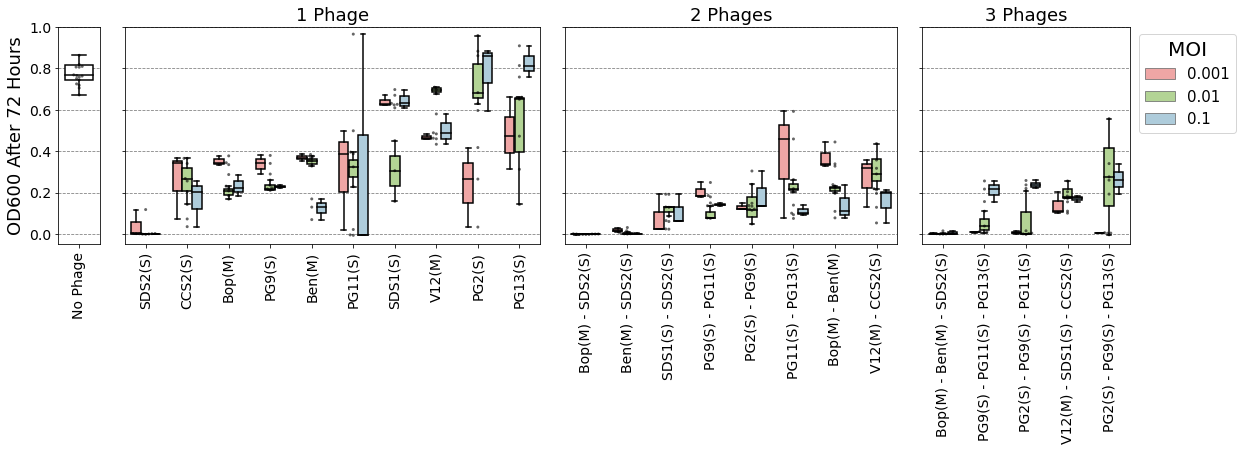

In [31]:
bac="EF06"
make_moi_boxplot(dat_merged_moi,bac, number_titles=True)

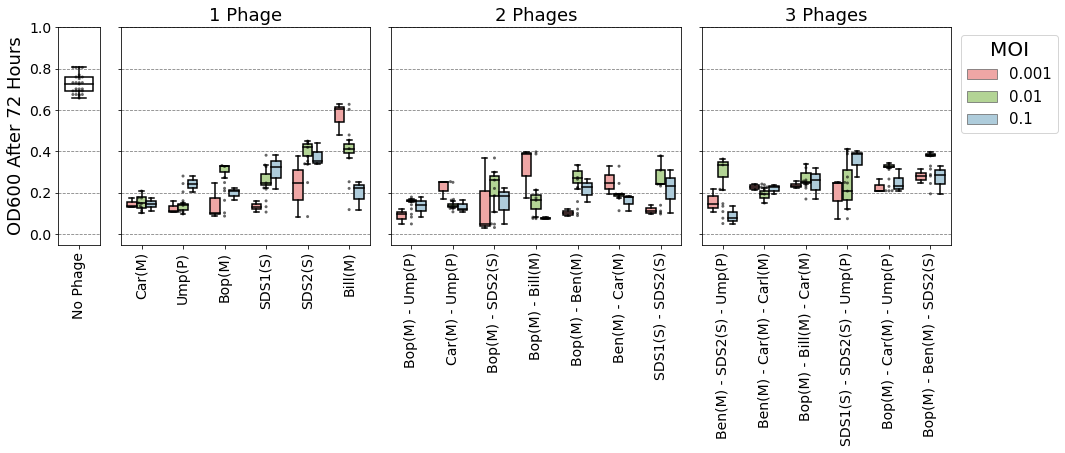

In [32]:
bac="EF11"
make_moi_boxplot(dat_merged_moi,bac, number_titles=True)